In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict
from decode_fish.funcs.exp_specific import *

from omegaconf import open_dict
from hydra import compose, initialize

initialize(config_path="../config")

hydra.initialize()

In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

# Training
Data taken from https://download.brainimagelibrary.org/cf/1c/cf1c1a431ef8d021/

In [4]:
def README():
    # This data collection contains spatially resolved single-cell transcriptomics datasets acquired using MERFISH on the mouse primary motor cortex (MOp) collected by the Xiaowei Zhuang Lab at Harvard University and Howard Hughes Medical Institute.

    # * The dataset contains MERFISH images of 12 experiments, which include 64 coronal slices of the MOp region (10 um thick slices, every 100um interval) collected from 2 biological replicates. For each mouse, 6 experiments were performed, and each experiment was named with the mouse id plus the sample id, e.g. mouse1_sample1, mouse2_sample3. For each experiment, multiple coronal slices (4-6 slices) were included on the same coverslip and were imaged together.

    # * In this dataset, a total of 258 genes were imaged. Among the 258 genes, 242 genes were imaged using MERFISH, which encodes individual genes with error-robust barcodes (22-bit binary codes in this case), imprints the barcodes onto the RNAs using combinatorial labeling with encoding probes, and measures the barcodes bit-by-bit using sequential hybridization of readout probes. The 22 bits are imaged in 11 hybridization rounds with two-color imaging each round. The remaining 16 genes were imaged by 8 sequential rounds of two-color FISH.

    # * Each of the subdirectory folders contains either the raw (e.g. mouse1_sample1_raw) or processed images (e.g. mouse1_sample1_processed) of one experiment. Each experiment contains many fields of view (FOVs) and each tiff file in the folder corresponds to the images of one FOV. The raw image files are named as aligned_images plus the FOV id (e.g. aligned_images0.tif); the processed image files are named as processed_images plus the FOV id (e.g. processed_images100.tif).

    # â€¢	{sample_id}_raw: folders containing raw images. Each raw image file, corresponding to one FOV, is a stacked tiff file of multiple frames, each frame corresponding to one z-plane of one channel and each channel corresponding to one bit of the MERFISH imaging process, or one gene imaged in the sequential hybridization process, or the DAPI and polyT images used for cell segmentation. Seven z-planes are imaged for each channel. Images are aligned by fiducial bead fitting across each imaging round. The tiff stacks are ordered as channel 1 z-planes 1 through 7, channel 2 z-planes 1 through 7, â€¦, channel 40 z-plane 1 through 7. See data_organization_raw.csv file for detailed channel information.

    # â€¢	{sample_id}_processed: folders containing processed images. Each processed image file, corresponding to one FOV, is a stacked tiff file of multiple frames, each frame corresponding to one z-plane of one channel and each channel corresponding to one bit of the MERFISH imaging process, or the DAPI and polyT images used for cell segmentation. Seven z-planes are imaged for each channel. Images are aligned by fiducial bead fitting across each imaging round, and processed with a high pass filter and deconvolution. The tiff stacks are ordered the same as the raw images, except that images for the genes imaged by straight sequential hybridization are not included. See data_organization_processed.csv file for detailed channel information, and preprocessing.json file for parameters used in image processing. 
    # Note: For the 650 nm channels, a significant number of spots observed the first z-plane (i.e. at the coverslip surface) correspond to non-specific binding of the 650 nm dye to the coverslip surface, and the vast majority of these non-specific binding spots are decoded as invalid barcodes in the decoding process and are not used for subsequent analysis.  

    # * The processed_data folder contains the following files:
    # â€¢	segmented_cells_{sample_id}.csv: Segmented cell boundary coordinates of each z-plane and the slice id that each cell belongs to for each experiment. Note that each experiment includes 4-6 tissue slices on a single coverslip, and the slice id gives the slice number that the cells belong to.
    # â€¢	spots_{sample_id}.csv: Decoded spot location (x,y,z) in the unit of microns and their target gene identity for each experiment. The same coordinate system was used in segmented_cells_{sample_id}.csv and spots_{sample_id}.csv for each experiment, and hence the spots can be parsed into the segmented cells (and also the slices) according by comparison of their coordinates with the cell boundary locations.  
    # â€¢	counts.h5ad: Cell by gene matrix of the whole dataset. The counts are normalized by the volume of each cell.
    # â€¢	cell_labels.csv: Cluster label assignment for each cell.

    # We also provide these files that are associated to this dataset:
    # â€¢	genes_combinatorial.txt: List of target genes that are imaged in combinatorial imaging rounds.
    # â€¢	genes_sequential.txt: List of target genes that are imaged sequentially after the combinatorial imaging rounds.
    # â€¢	probes.fasta: Provides sequences all encoding probes used for hybridization.
    # â€¢	codebook.csv: Provides the barcodes that encode individual genes measured in the combinatorial imaging rounds.
    # â€¢	data_organization_raw.csv: Provides information on how individual channels and z-planes are ordered in the multi-frame tiff file for each field of view of raw images.
    # â€¢	data_organization_processed.csv: Provides information on how individual channels and z-planes are ordered in the multi-frame tiff file for each field of view of processed images.
    # â€¢	microscope.json: Provides parameters of the microscope that was used with pixel size and orientation of images.
    # â€¢	preprocessing.json: Provides values and filters used in generating the processed images.
    # â€¢	fov_positions folder: contains the txt files of field of view positions for individual samples, named by its sample id.
    
    return

Own Notes: z-bins given in data_organization_raw.csv: 0.,1.5,3.,4.5,6.,7.5,9.

Values in the the prediction files: 0., 1.38248848, 2.76497696, 4.14746544, 5.52995392, 6.9124424 , 8.29493088

1.4 um would correspond to 13 pixels in x-y

In [281]:
zbins = np.array([0.,1.5,3.,4.5,6.,7.5,9.]) 
len(zbins)

7

In [137]:
cfg = compose(config_name='train.yaml', overrides= ["+exp_type=merfish_MOp"])
# cfg = OmegaConf.create(cfg)

Make dataset specific changes

In [138]:
thetas = [79.11,20.9942,11.0078,41.7738,31.2776,14.7114,37.665,9.66,11.956,23.7223,26.4227,8.6138,46.759,4.8934,9.4187,47.1626,26.786,6.9419,28.795,11.7935,5.9558,23.017]
thetas = [t / 5 for t in thetas]
channels_facs = [t / min(thetas) for t in thetas]
# channels_facs = [1. for t in thetas]

In [139]:
cfg.output.project = 'MERFISH_MOp'
# cfg.output.group='sweep_sl_4'
# cfg.sub_name='scaled'

# Path to the recording you want to train the network on. Can also use a * expression to load multiple tiffs (e.g. path/*.tif)
cfg.data_path.image_path = cfg.base_dir + '/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images150.tif'

# We initialize the PSF as a Gaussian with the given radii. Should be adjusted to get a rough visual fit between recording and simulation.
cfg.data_path.psf_path = None
cfg.genm.PSF.psf_extent_zyx = [3,13,13]
cfg.genm.PSF.gauss_radii = [.5,1.7,1.7]
cfg.genm.PSF.n_cols = 1

cfg.evaluation.reconstruction.crop_sl = 's_[:,:,500:700,1400:1600]'

# Average number of foci per simulated volume. If your data does not contain any foci set this to 0.
cfg.genm.foci.n_foci_avg = 0
# Lower and upper limit of emitters simulated per focus
cfg.genm.foci.n_mol_range: [5,40]

# Sets the intensity scale of the simulation. Should be adjusted to cover observed intensity values 

cfg.genm.prob_generator.low = 0.0002
cfg.genm.prob_generator.high = 0.03

# Set to 'disabled' if you do not have a wandb account.
cfg.output.wandb_mode = 'online'

cfg.network.f_maps = 256
cfg.network.depth = 2
cfg.training.bs = 3

cfg.genm.noise.theta = thetas
cfg.genm.microscope.ch_facs = channels_facs

cfg.sim.roi_mask.percentile = 20
cfg.sim.random_crop.crop_sz = 48

cfg.genm.microscope.norm = 'none'
cfg.genm.microscope.psf_noise = 0.0
cfg.sim.bg_estimation.smoothing.smoothing_filter_size = 9

cfg.genm.intensity_dist.int_conc = 4.
cfg.genm.intensity_dist.int_rate = 1.
cfg.genm.intensity_dist.int_loc = .5

cfg.training.num_iters = 50000
cfg.training.int.enabled = False
cfg.training.mic.enabled = True

cfg.training.bl_loss_scale: 0.005

cfg.training.net.min_int_sig = 1.0
cfg.genm.microscope.scale = 60
cfg.sim.bg_estimation.fractal.scale = 0

cfg.run_name ='MERFISH_mop_1b'

cfg.training.int_option = 1.
cfg.training.mic.norm_reg = 0.

cfg.evaluation.code_stats.enabled = False
cfg.output.log_interval = 200

cfg.genm.emitter_noise.rate_fac = 3.
cfg.genm.emitter_noise.int_fac = 0.25

cfg.training.start_mic = 100000
cfg.training.start_int = 100000

cfg.training.net.opt.lr = 2e-4
cfg.training.int_option = 2e-4

In [141]:
# cfg.run_name ='MERFISH_mop_1a_ae'
# cfg.training.int.enabled = True
# cfg.training.mic.enabled = True
# cfg.training.start_mic = 0
# cfg.training.start_int = 0

In [142]:
fname = f'../config/experiment/{cfg.run_name}.yaml'
OmegaConf.save(cfg, fname)
prepend_line(fname, '# @package _global_')
cfg.run_name

'MERFISH_mop_1b'

In [10]:
home_dir = os.getenv("HOME")
print(f'bsub -gpu "num=1" -q gpu_rtx -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode_fish_dev2/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name} run_name=100genes')

bsub -gpu "num=1" -q gpu_rtx -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=MERFISH_mop_1a run_name=100genes


Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  
For visualization purposes it is often better to not sample foci as they distort the colorscale.

In [11]:
# n_foci = cfg.genm.foci.n_foci_avg
# cfg.genm.foci.n_foci_avg = 0
# img_3d, decode_dl = get_dataloader(cfg)
# cfg.genm.foci.n_foci_avg = n_foci
psf, noise, micro = load_psf_noise_micro(cfg)

In [12]:
fig1, axes = plot_3d_projections(img_3d[0][5], size=5, proj_func=np.max, display=False)
sl = eval(cfg.evaluation.reconstruction.crop_sl,{'__builtins__': None},{'s_': np.s_})
fig2, axes = plot_3d_projections(img_3d[0][sl][5], size=5, display=False)
_ = combine_figures([fig1,fig2], titles=['Full Fov', 'Eval FoV'])

NameError: name 'img_3d' is not defined

In [ ]:
plot_channels(img_3d[0][sl], 2, display=False, vmax=20000)

In [ ]:
from scipy import stats
def estimate_noise_scale(img, bg_est, percentile=99, plot=True):
    """ Returns an estimate of theta given a volume and a background estimate 
    
    Args:
        img: recorded volume for which we want to estimate the noise 
        bg_est: estimated background for img
        percentile: we wan't to exclude the signal for our fit. therefore we only use the lower percentile of all voxels
        plot: whether to plot the data and the final fit
        
    Returns:
        fit_theta: theta estimate
    """
    
    img = cpu(img)
    bg_est = cpu(bg_est)
    residual = np.clip(img - bg_est + bg_est.mean(), img.min(), 1e10)
    fit_vals = residual[residual < np.percentile(residual, percentile)]
    fit_vals = fit_vals[fit_vals > np.percentile(fit_vals, 100-percentile)]
    fit_alpha, fit_loc, fit_theta=stats.gamma.fit(fit_vals, floc=0)   

    if plot:
        _ = plt.hist(fit_vals,bins=np.linspace(fit_vals.min(),fit_vals.max(), 51),  histtype ='step',label='data', density=True)
        x = np.linspace(fit_vals.min(),fit_vals.max(),101)
        y = stats.gamma.pdf(x, fit_alpha, fit_loc, fit_theta)
        plt.plot(x, y, label='Fit')
        plt.legend()
        
    return fit_theta

In [ ]:
# img = load_tiff_image(cfg.data_path.image_path)
thetas = []
for i in range(22):
    bg_est = hydra.utils.instantiate(cfg.sim.bg_estimation.smoothing)(img_3d[0][i,:,:500,1500:].to('cuda'))
    theta = estimate_noise_scale(img_3d[0][i,:,:500,1500:], bg_est, percentile=99, plot=False)
#     plt.show()
    thetas.append(theta)

In [ ]:
plt.plot(thetas)

In [ ]:
bench_df, code_ref, targets = hydra.utils.instantiate(cfg.codebook)

In [ ]:
plot_3d_projections(torch.tensor(psf.psf_volume)[0])

This function allows you to visually compare the recorded data and the simulations generated with the given config.  
For each sample we plot a slice from the input volume and from a simulated training volume as well as the estimated background.  
In the second row we compare maximum intensity projections.  

Adjust the microscope.scale and PSF.gauss_radii until you achieve a rough match in intensities and the PSF shape.  
You don't have to get this exactly right as these values get automatically fine tuned during training.
It is totally fine if average density of emitters in the simulations is higher than in the recordings.

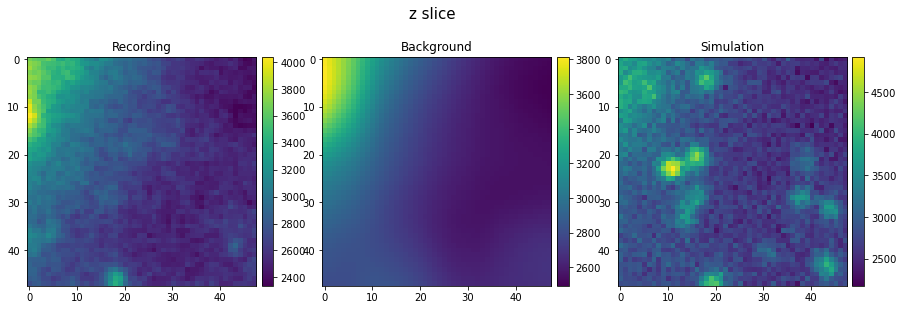

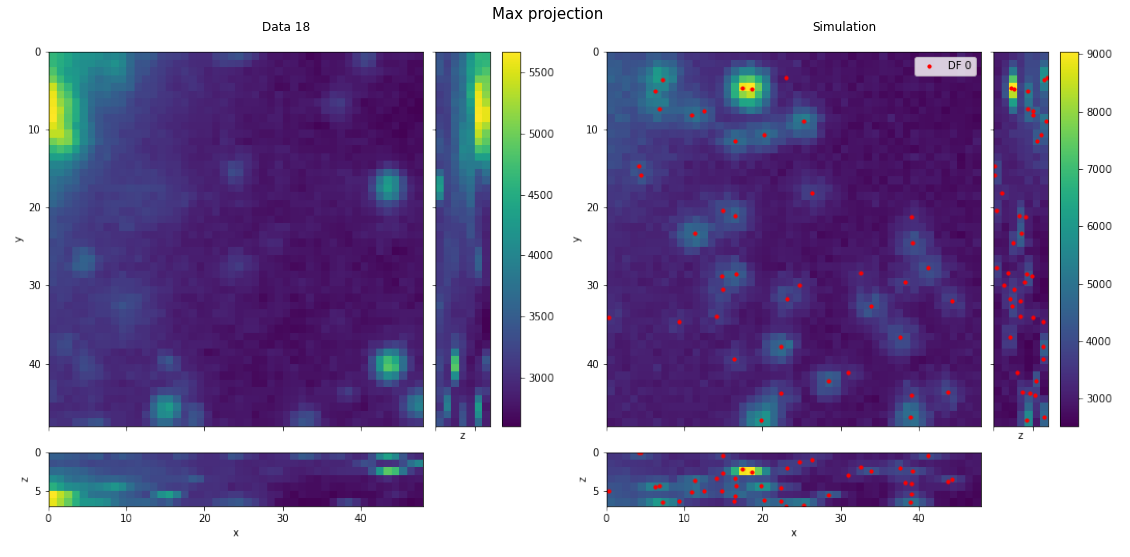

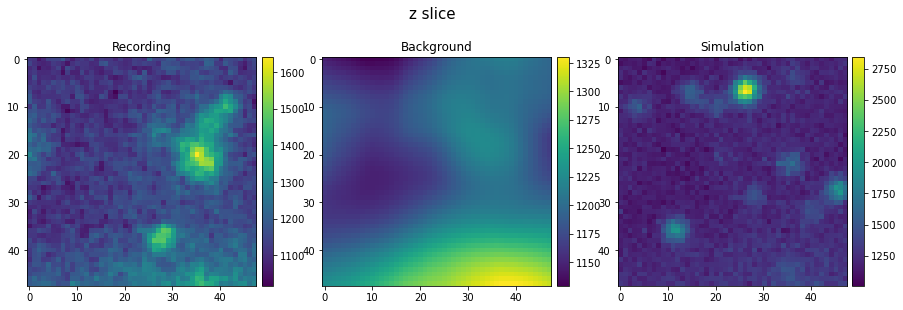

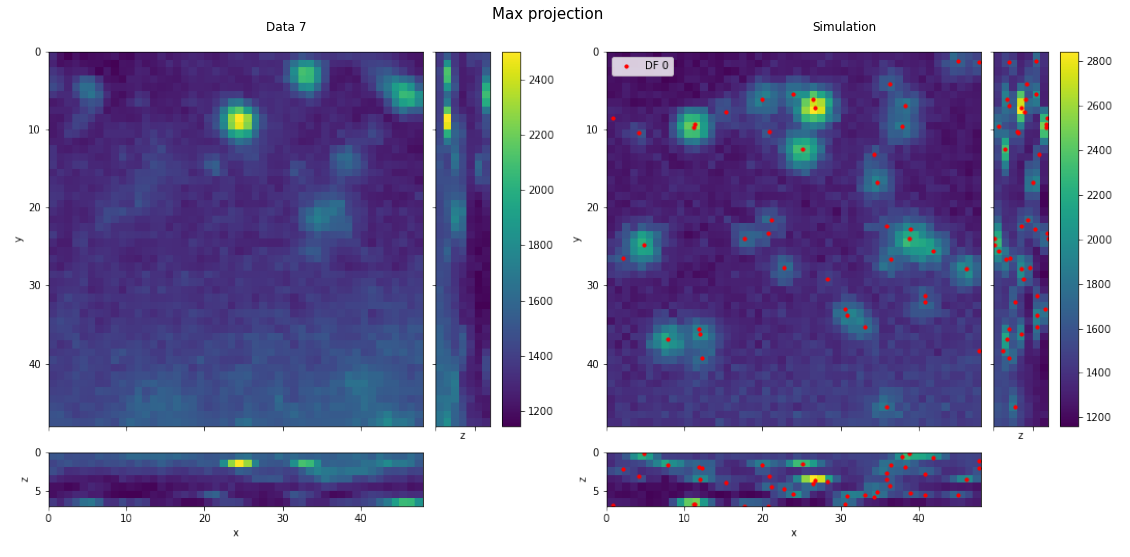

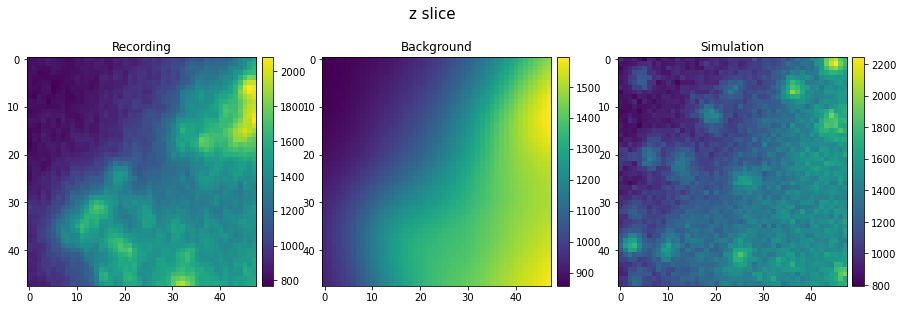

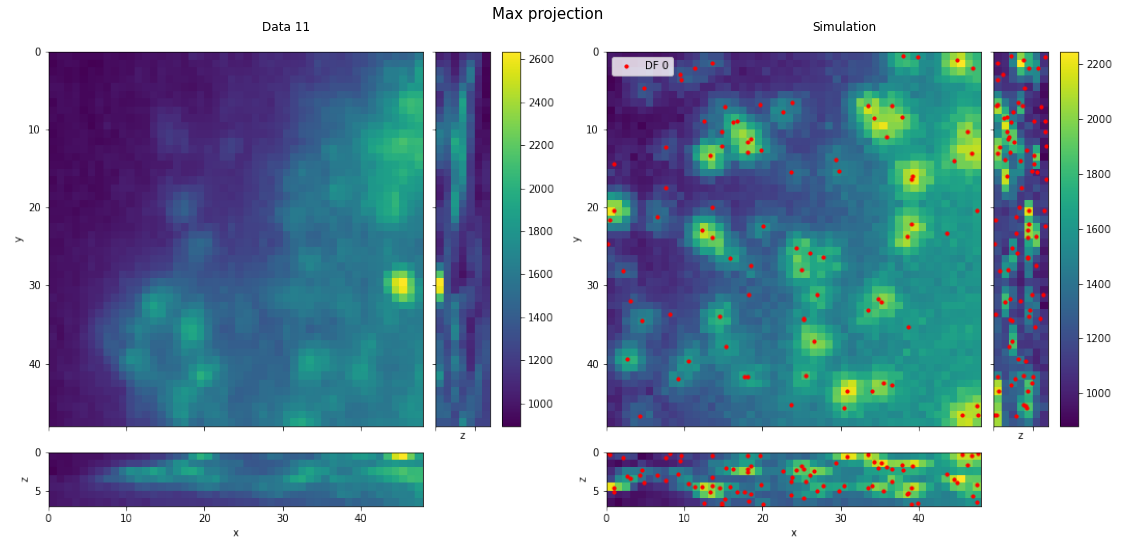

In [228]:
get_simulation_statistics(decode_dl, micro, **cfg.genm.intensity_dist, int_threshold=0.1, samples=3, channels=cfg.genm.exp_type.n_channels, n_bits=cfg.genm.exp_type.n_bits, psf_noise=False, codebook=torch.tensor(code_ref))

# Evaluation

In [432]:
# cfg.run_name = 'test'
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_1a/lr:0.0002xint_option:3/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_1b/n_foci_avg:1xpsf_noise:0.0//train.yaml')

In [433]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_1b/n_foci_avg:0xpsf_noise:0.3//train.yaml')
_ = load_model_state(model, Path(cfg.output.save_dir)/'model.pkl')

In [434]:
bench_df, code_ref, targets = hydra.utils.instantiate(cfg.codebook, return_bench_df=True)
bench_df = get_mop_fov(bench_df, 150)

17130008


In [435]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
# model, post_proc, _, _, _= load_all(cfg)
psf_init = get_gaussian_psf(cfg.genm.PSF.psf_extent_zyx,cfg.genm.PSF.gauss_radii, cfg.genm.exp_type.pred_z, cfg.genm.PSF.n_cols)
psf_init = cpu(psf_init.psf_volume)
psf_vol = cpu(micro.psf.psf_volume)
post_proc.codebook = torch.tensor(code_ref)

Crop size larger than volume in at least one dimension. Crop size changed to (7, 48, 48)
1 volumes


Plot mean projections of the PSF before and after optimizing it during training

(tensor(1., device='cuda:0', grad_fn=<DivBackward0>), tensor(6.0000, device='cuda:0', grad_fn=<DivBackward0>), tensor(6.0000, device='cuda:0', grad_fn=<DivBackward0>))


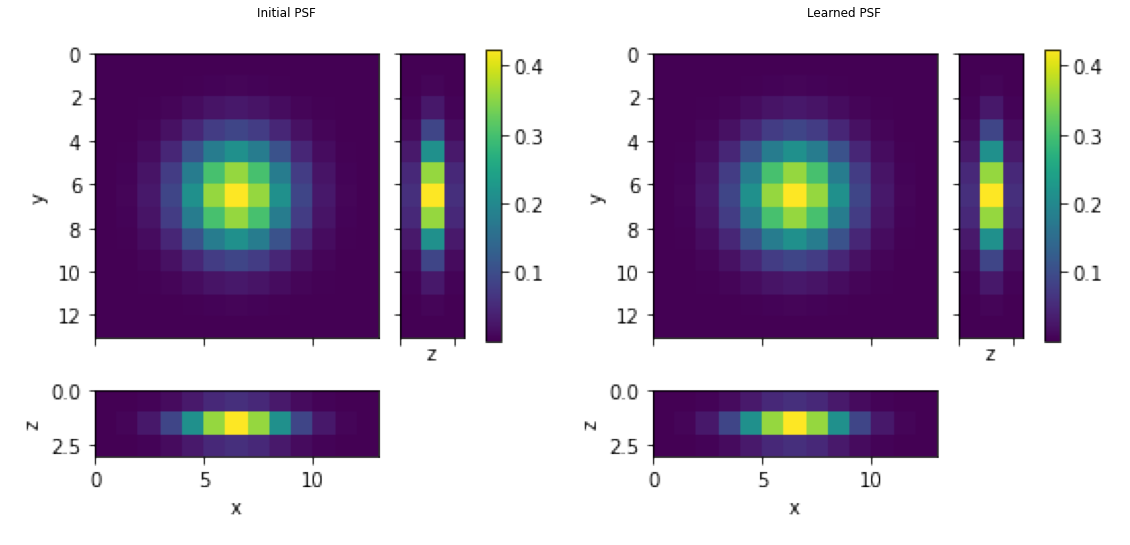

In [210]:
print(micro.psf.get_com())
fig1,_ =plot_3d_projections(psf_init[0], proj_func=np.mean, size=3, display=False)
fig2,_ =plot_3d_projections(psf_vol[0], proj_func=np.mean, size=3, display=False)
_ = combine_figures([fig1,fig2],['Initial PSF','Learned PSF'], nrows=1, ncols=2, figsize=(20,10))

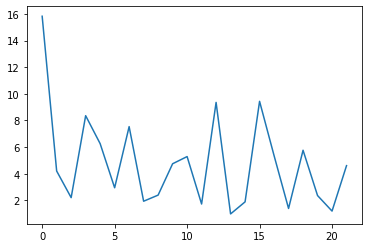

In [211]:
plt.plot(cpu(micro.noise.theta_par.to('cpu')*micro.noise.theta_scale))

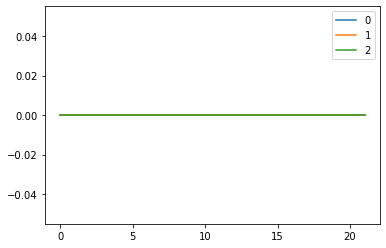

In [212]:
for i in range(3):
    plt.plot(cpu(micro.noise.channel_shifts[:,i]), label=i)
plt.legend()

Sample random sub volumes and overlay them with predictions,  also shows the residuals between the input volume and the reconstruction from applying the microscope and PSF model to those predictions. Sometimes it looks like the network if missing obvious molecules. Often times this is because they are at the very edge of the volume. In that case they will be localized once you process the whole volume.

In [329]:
def eval_random_crop(decode_dl, model, post_proc, micro, proj_func=np.max, cuda=False, samples=1, int_threshold=1, plot='rec', crop_sz_xy=40, ret_preds=False):
    
    with torch.no_grad():
        
        dl_copy = copy.deepcopy(decode_dl)
        dl_copy.dataset.dataset_tfms[0].crop_sz = (dl_copy.dataset.dataset_tfms[0].crop_sz[0], crop_sz_xy, crop_sz_xy)
        
        if ret_preds: samples = 1
        
        for _ in range(samples):
        
            x = torch.zeros(1)
            while x.max() < int_threshold:
                x, local_rate, background = next(iter(dl_copy))
                x = x[:1]; local_rate = local_rate[:1]; background = background[:1]
                
            rand_ch = np.random.randint(0, x.shape[1])
            print(rand_ch)
            pred_df, rec, res_dict = get_prediction(model, post_proc, x, micro=micro, cuda=True, return_rec=True, channel=rand_ch)
            pred_df = nm_to_px(pred_df, post_proc.px_size_zyx)
            
            sub_df = pred_df#[code_ref[pred_df['code_inds']][:,rand_ch] > 0]

            x_plot = x[0,rand_ch].cpu().numpy()
            rec = rec[0,rand_ch].cpu().numpy()

            fig1, axes = plot_3d_projections(x_plot, proj_func=proj_func, display=False)
            scat_3d_projections(axes, [sub_df])
            
            if 'res' in plot:

                diff = abs(x_plot-rec)
                fig2, axes = plot_3d_projections(diff, proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'Residual'], figsize=(20,10))
  
            if 'rec' in plot:

                fig2, axes = plot_3d_projections(rec, proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'Reconstruction'], figsize=(20,10))
                
            if 'bg' in plot:

                fig2, axes = plot_3d_projections(res_dict['background'], proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'BG pred.'], figsize=(20,10))
                
            plt.show()
                
        if ret_preds:
            
            return x, local_rate, background, pred_df, rec, res_dict
                        

In [324]:
model.inp_scale = torch.ones([22]) * model.inp_scale
model.inp_offset = torch.ones([22]) * model.inp_offset

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [219]:
model.inp_scale = model.inp_scale.cuda()
model.inp_offset = model.inp_offset.cuda()

2


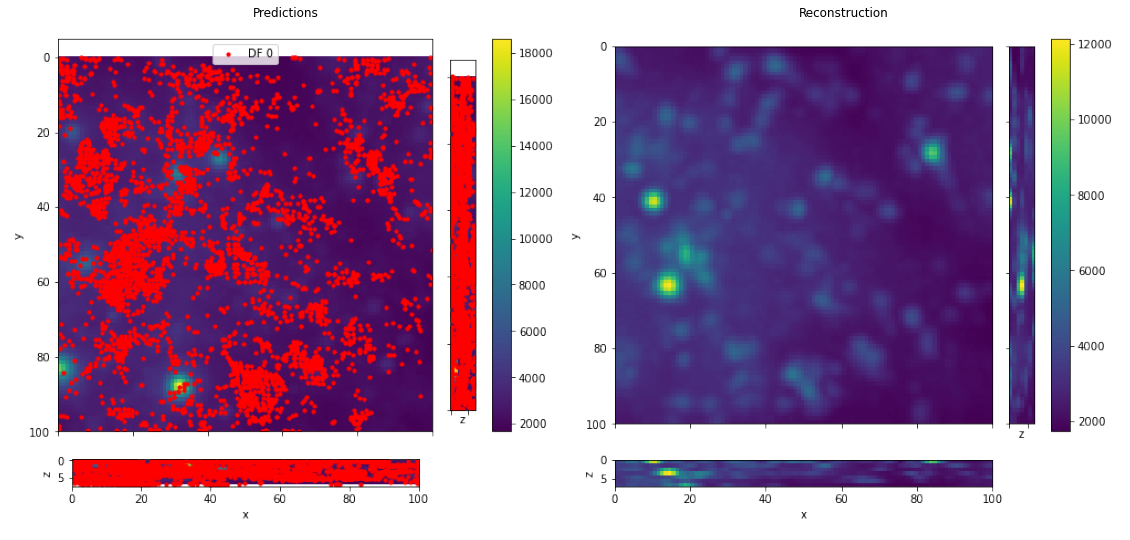

In [374]:
x, local_rate, background, pred_df, rec, res_dict = eval_random_crop(decode_dl, model, post_proc, micro, plot='rec', crop_sz_xy=100, ret_preds=True)
# eval_random_crop(decode_dl, model, post_proc, micro, samples=10, plot='rec', crop_sz_xy=100, ret_preds=True)

In [338]:
res_dict['logits'].shape

torch.Size([1, 252, 7, 100, 100])

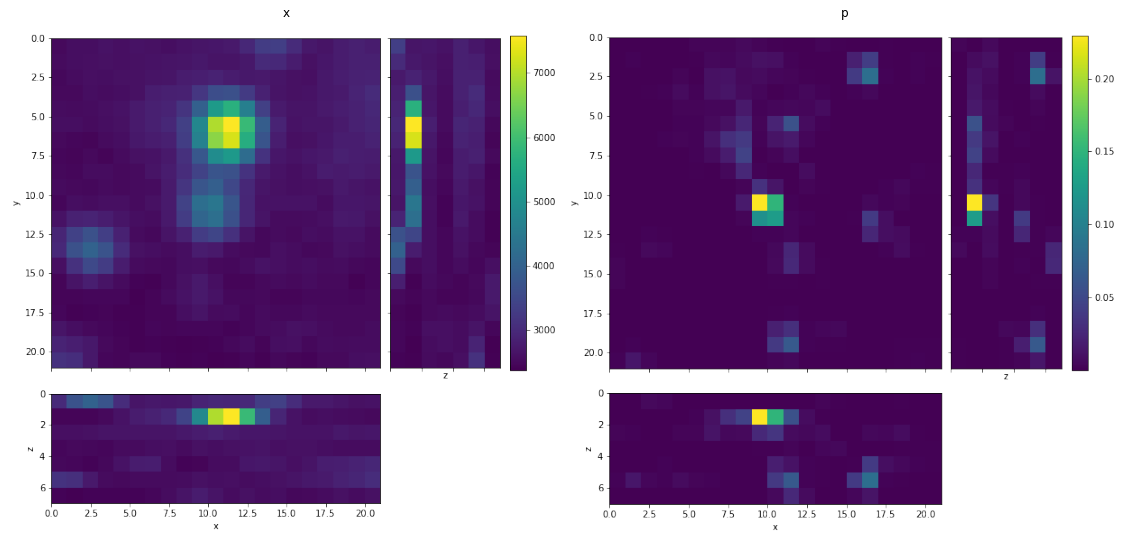

In [366]:
coords = [27,35,4]
w = 10

plot_vol, crop = extract_roi(x[0], coords, w, w)
fig1, axes =plot_3d_projections(plot_vol[18], display=False)

plot_vol, crop = extract_roi(cpu(torch.sigmoid(res_dict['logits'][0])), coords, w, w)
fig2, axes =plot_3d_projections(plot_vol.max(0), display=False)

_ = combine_figures([fig1,fig2], titles=['x','p'], figsize=(20,10))

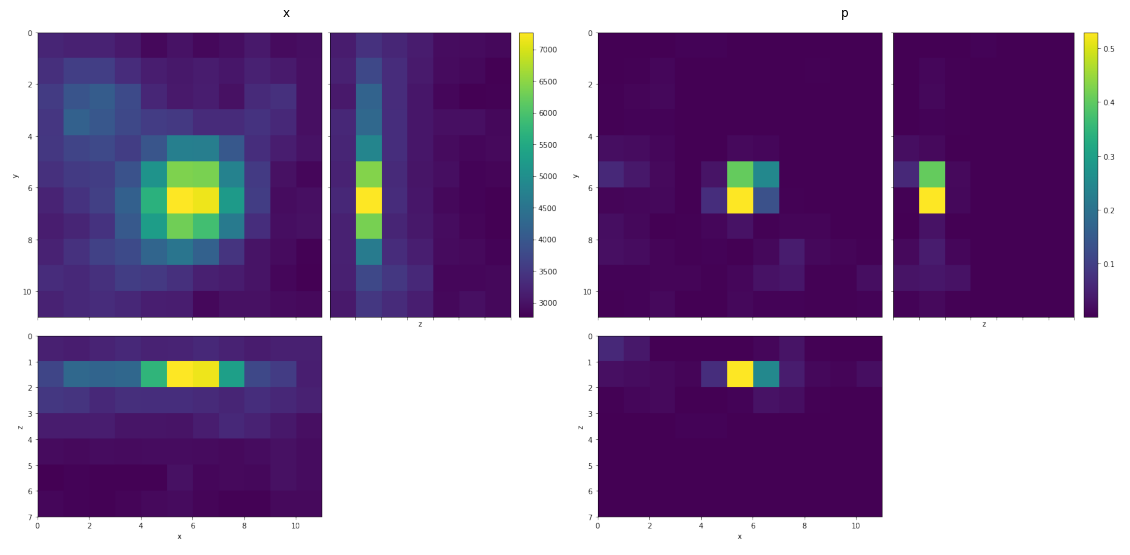

In [360]:
coords = [90,73,4]
w = 5

plot_vol, crop = extract_roi(x[0], coords, w, w)
fig1, axes =plot_3d_projections(plot_vol[15], display=False)

plot_vol, crop = extract_roi(cpu(torch.sigmoid(res_dict['logits'][0])), coords, w, w)
fig2, axes =plot_3d_projections(plot_vol.max(0), display=False)

_ = combine_figures([fig1,fig2], titles=['x','p'], figsize=(20,10))

In [200]:
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.output_trafo import *
with torch.no_grad():
#     x, local_rate, background = next(iter(decode_dl))
    sim_vars = PointProcessUniform(local_rate[:,0], int_conc=model.int_dist.int_conc.detach(), 
                                   int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                   sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=cfg.genm.exp_type.n_bits, 
                                   sim_z=cfg.genm.exp_type.pred_z, codebook=torch.tensor(code_ref, dtype=torch.bool), int_option=cfg.training.int_option).sample(from_code_book=True)
    
    xsim = micro(*sim_vars[:-1], add_noise=True)
    xsimn = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

    gt_df = sample_to_df(*sim_vars[:5],sim_vars[-1], px_size_zyx=[1.,1.,1.])

    print(len(gt_df))

    model.eval().cuda()
    res_dict_sim = model(xsimn.cuda())
    res_dict_sim = model.tensor_to_dict(res_dict_sim)
    res_dict_sim['xyzi_mu'][:,3:] = res_dict_sim['xyzi_mu'][:,3:]# * 0  + torch.tensor(gt_ints)[:,:,None,None,None].cuda()
    res_dict_sim['xyzi_sigma'][:,3:] = res_dict_sim['xyzi_sigma'][:,3:] 
#     count_prob, spatial_prob = PointProcessGaussian(**res_dict_sim).log_prob(*sim_vars[:5], 
#                                                   n_bits=cfg.exp_type.n_bits, channels=cfg.exp_type.channels, min_int_sig=cfg.training.net.min_int_sig)
    
    pred_df_sim = post_proc.get_df(res_dict_sim)
    pred_df_sim = nm_to_px(pred_df_sim, post_proc.px_size_zyx)

718


In [300]:
def plot_channels(volume, n_rows=1, df=None, codebook=None, proj_func=np.max, size=6, vmax=None, center=None, crop_sz=10, display=True):

    if torch.is_tensor(volume):
        plot_vol = volume.detach().cpu().numpy()
    else:
        plot_vol = volume
        
    for _ in range(plot_vol.ndim - 4):
        plot_vol = plot_vol.squeeze(0)
        
    ch = plot_vol.shape[0]
    n_cols = int(np.ceil(ch/n_rows))
    
    if center is not None:
        plot_vol, crop = extract_roi(plot_vol, center, crop_sz, crop_sz)
        if df is not None:
            df = crop_df(df, crop)
    
    size_y = size * n_rows
    size_x = size * n_cols
        
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(size_x,size_y))
    plt.subplots_adjust(hspace=0.0,wspace=0.05)
    print(axes.shape)
#     if vmax is None:
#         vmax = plot_vol.max()
    
    for i in range(n_rows):
        for j in range(n_cols):
            
            curr_ind = i*n_cols + j
            if curr_ind >= len(plot_vol):
                continue
            
            im = axes[i, j].imshow(proj_func(plot_vol[curr_ind], 0),vmax=vmax)
            axes[i, j].axis('off')
            
            if df is not None:
                sub_df = df[codebook[df['code_inds']][:,curr_ind] > 0]
                axes[i, j].scatter(sub_df['x'],sub_df['y'], color='red', s=10)
                
            if center is not None:
                axes[i, j].scatter(crop_sz,crop_sz, color='purple', s=125, marker='+')
    
#     fig.colorbar(im)
    
    plt.tight_layout()
    
    if not display: plt.close(fig)

    return fig

def extract_roi(beads: torch.Tensor, coordinates: torch.Tensor, size_xy: int=10, size_z: int=10):
    res = []
    
    x, y, z = coordinates
    crop = np.s_[:,:, int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

(4, 6)


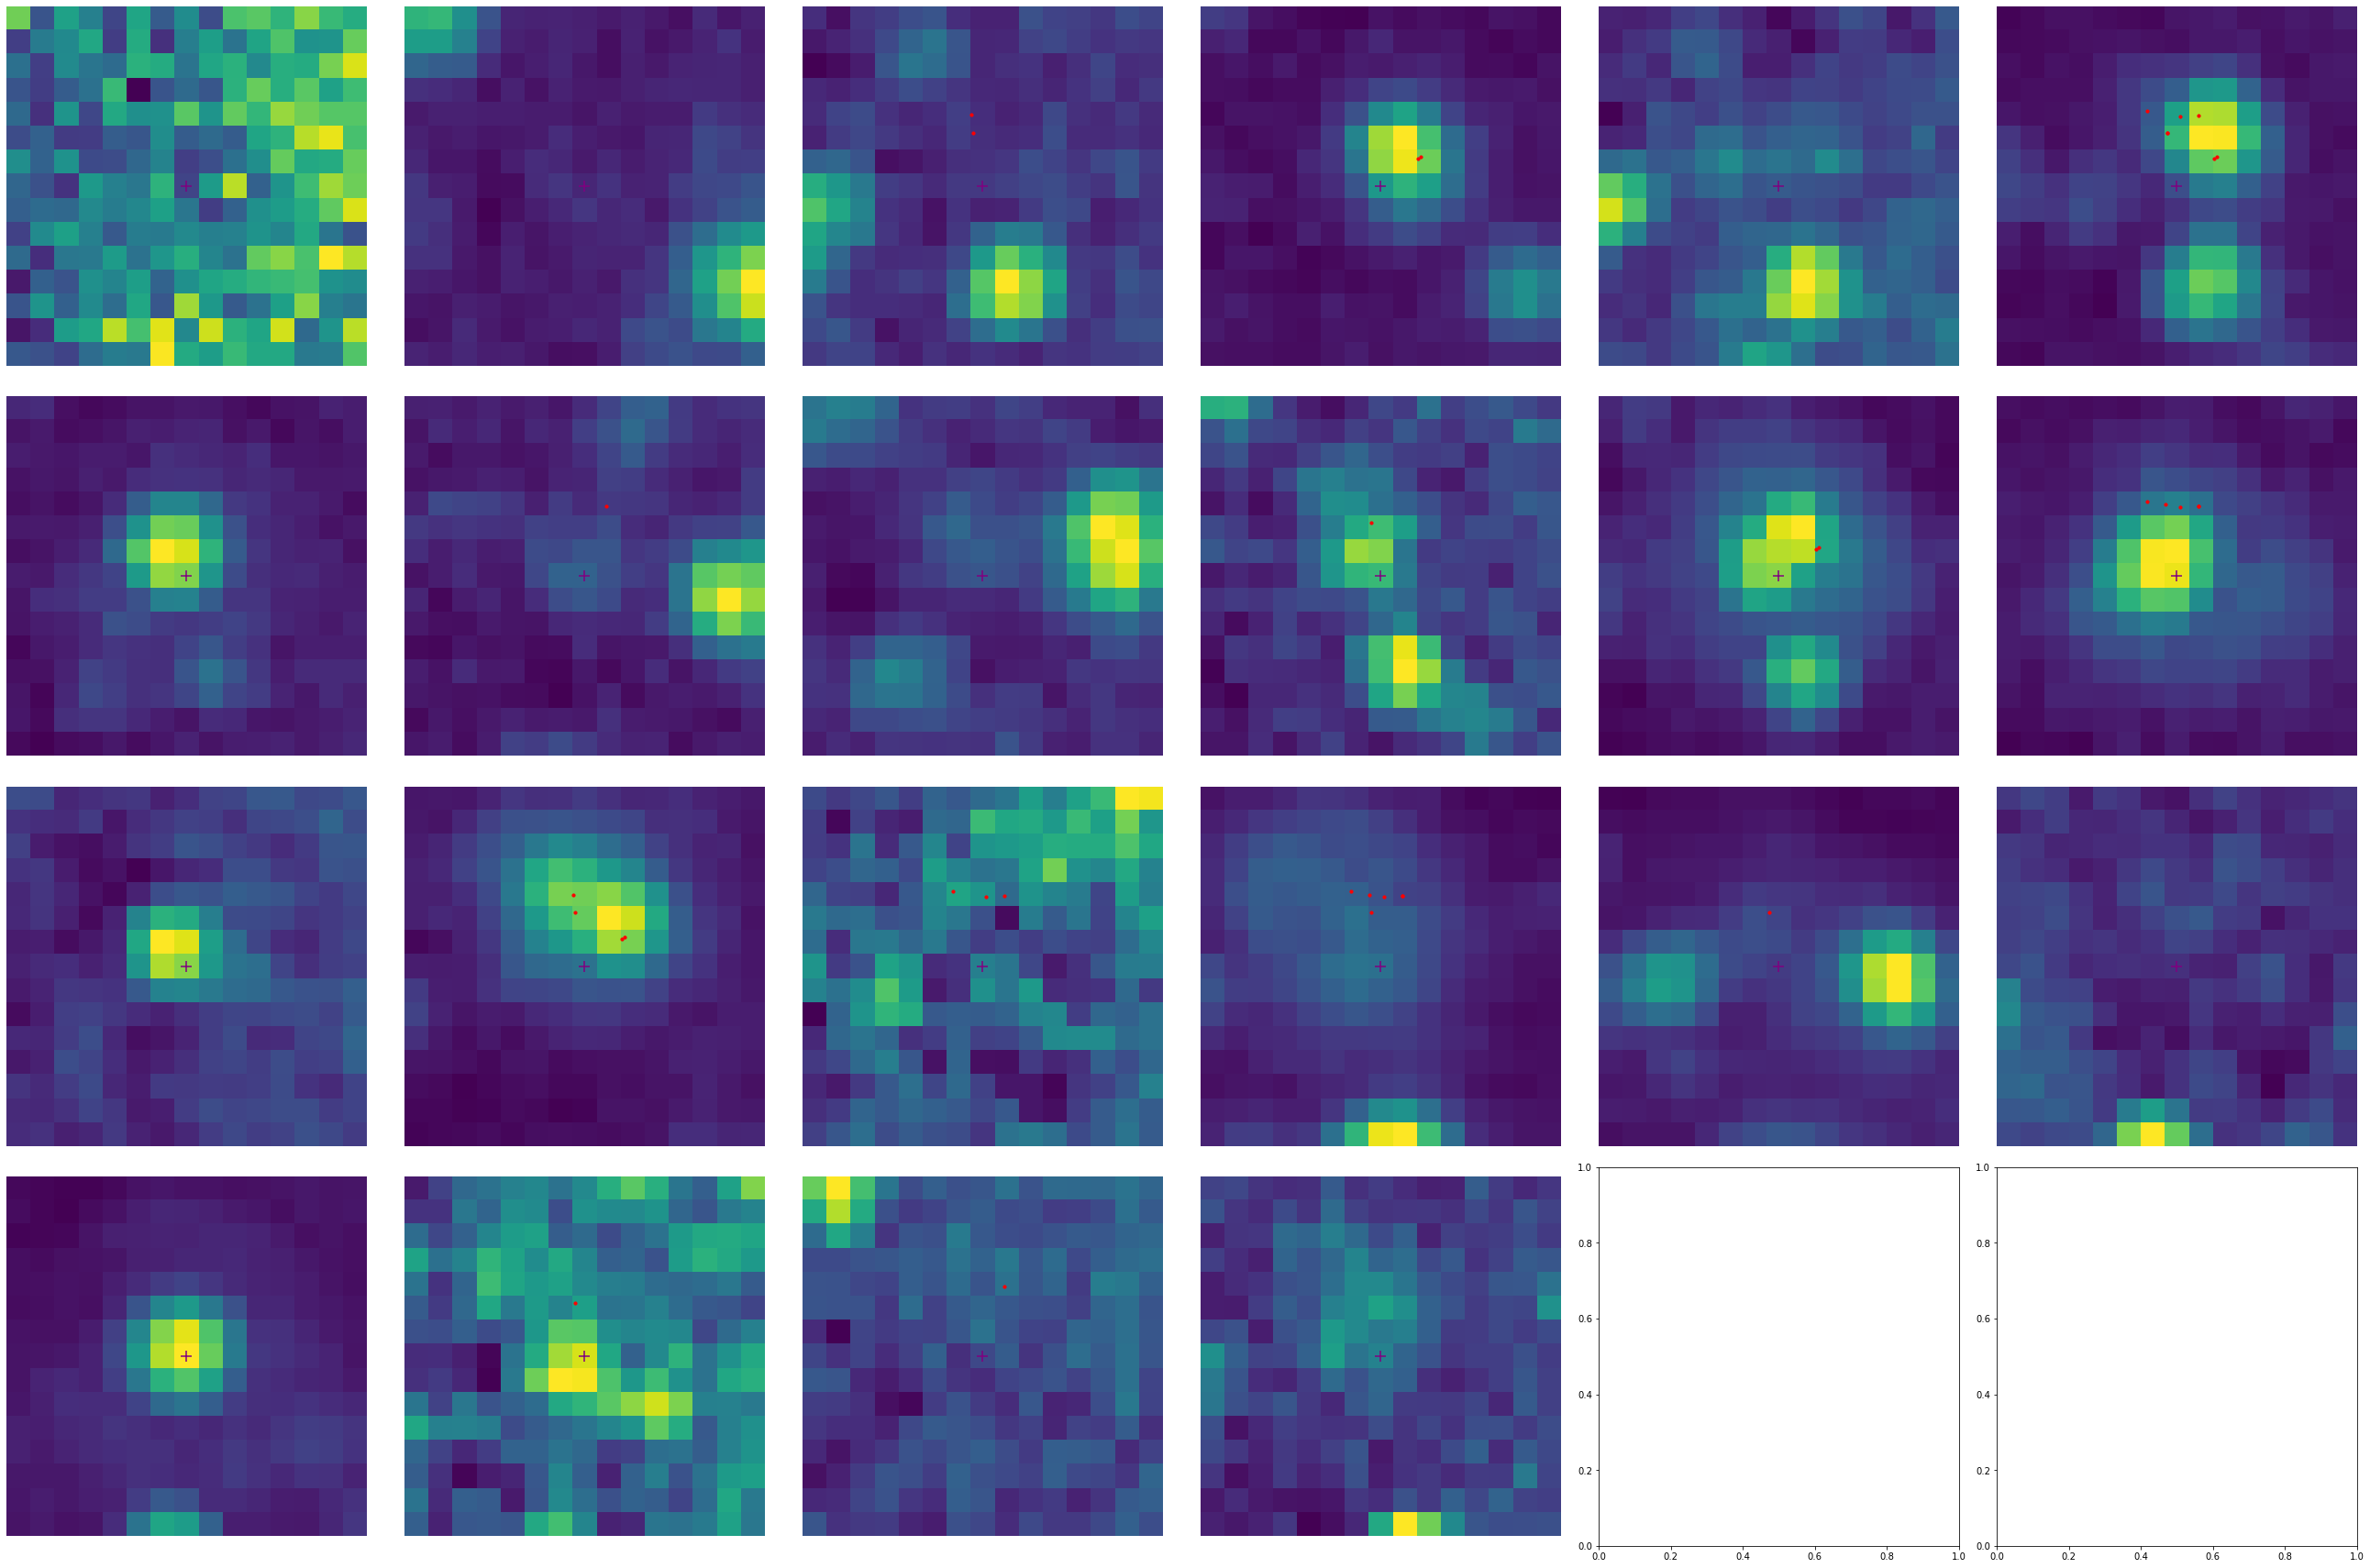

In [371]:
_ = plot_channels(cpu(x[0]), n_rows=4, df=pred_df, codebook=code_ref, vmax=None, center=[90,90,4], crop_sz=7)

(4, 6)


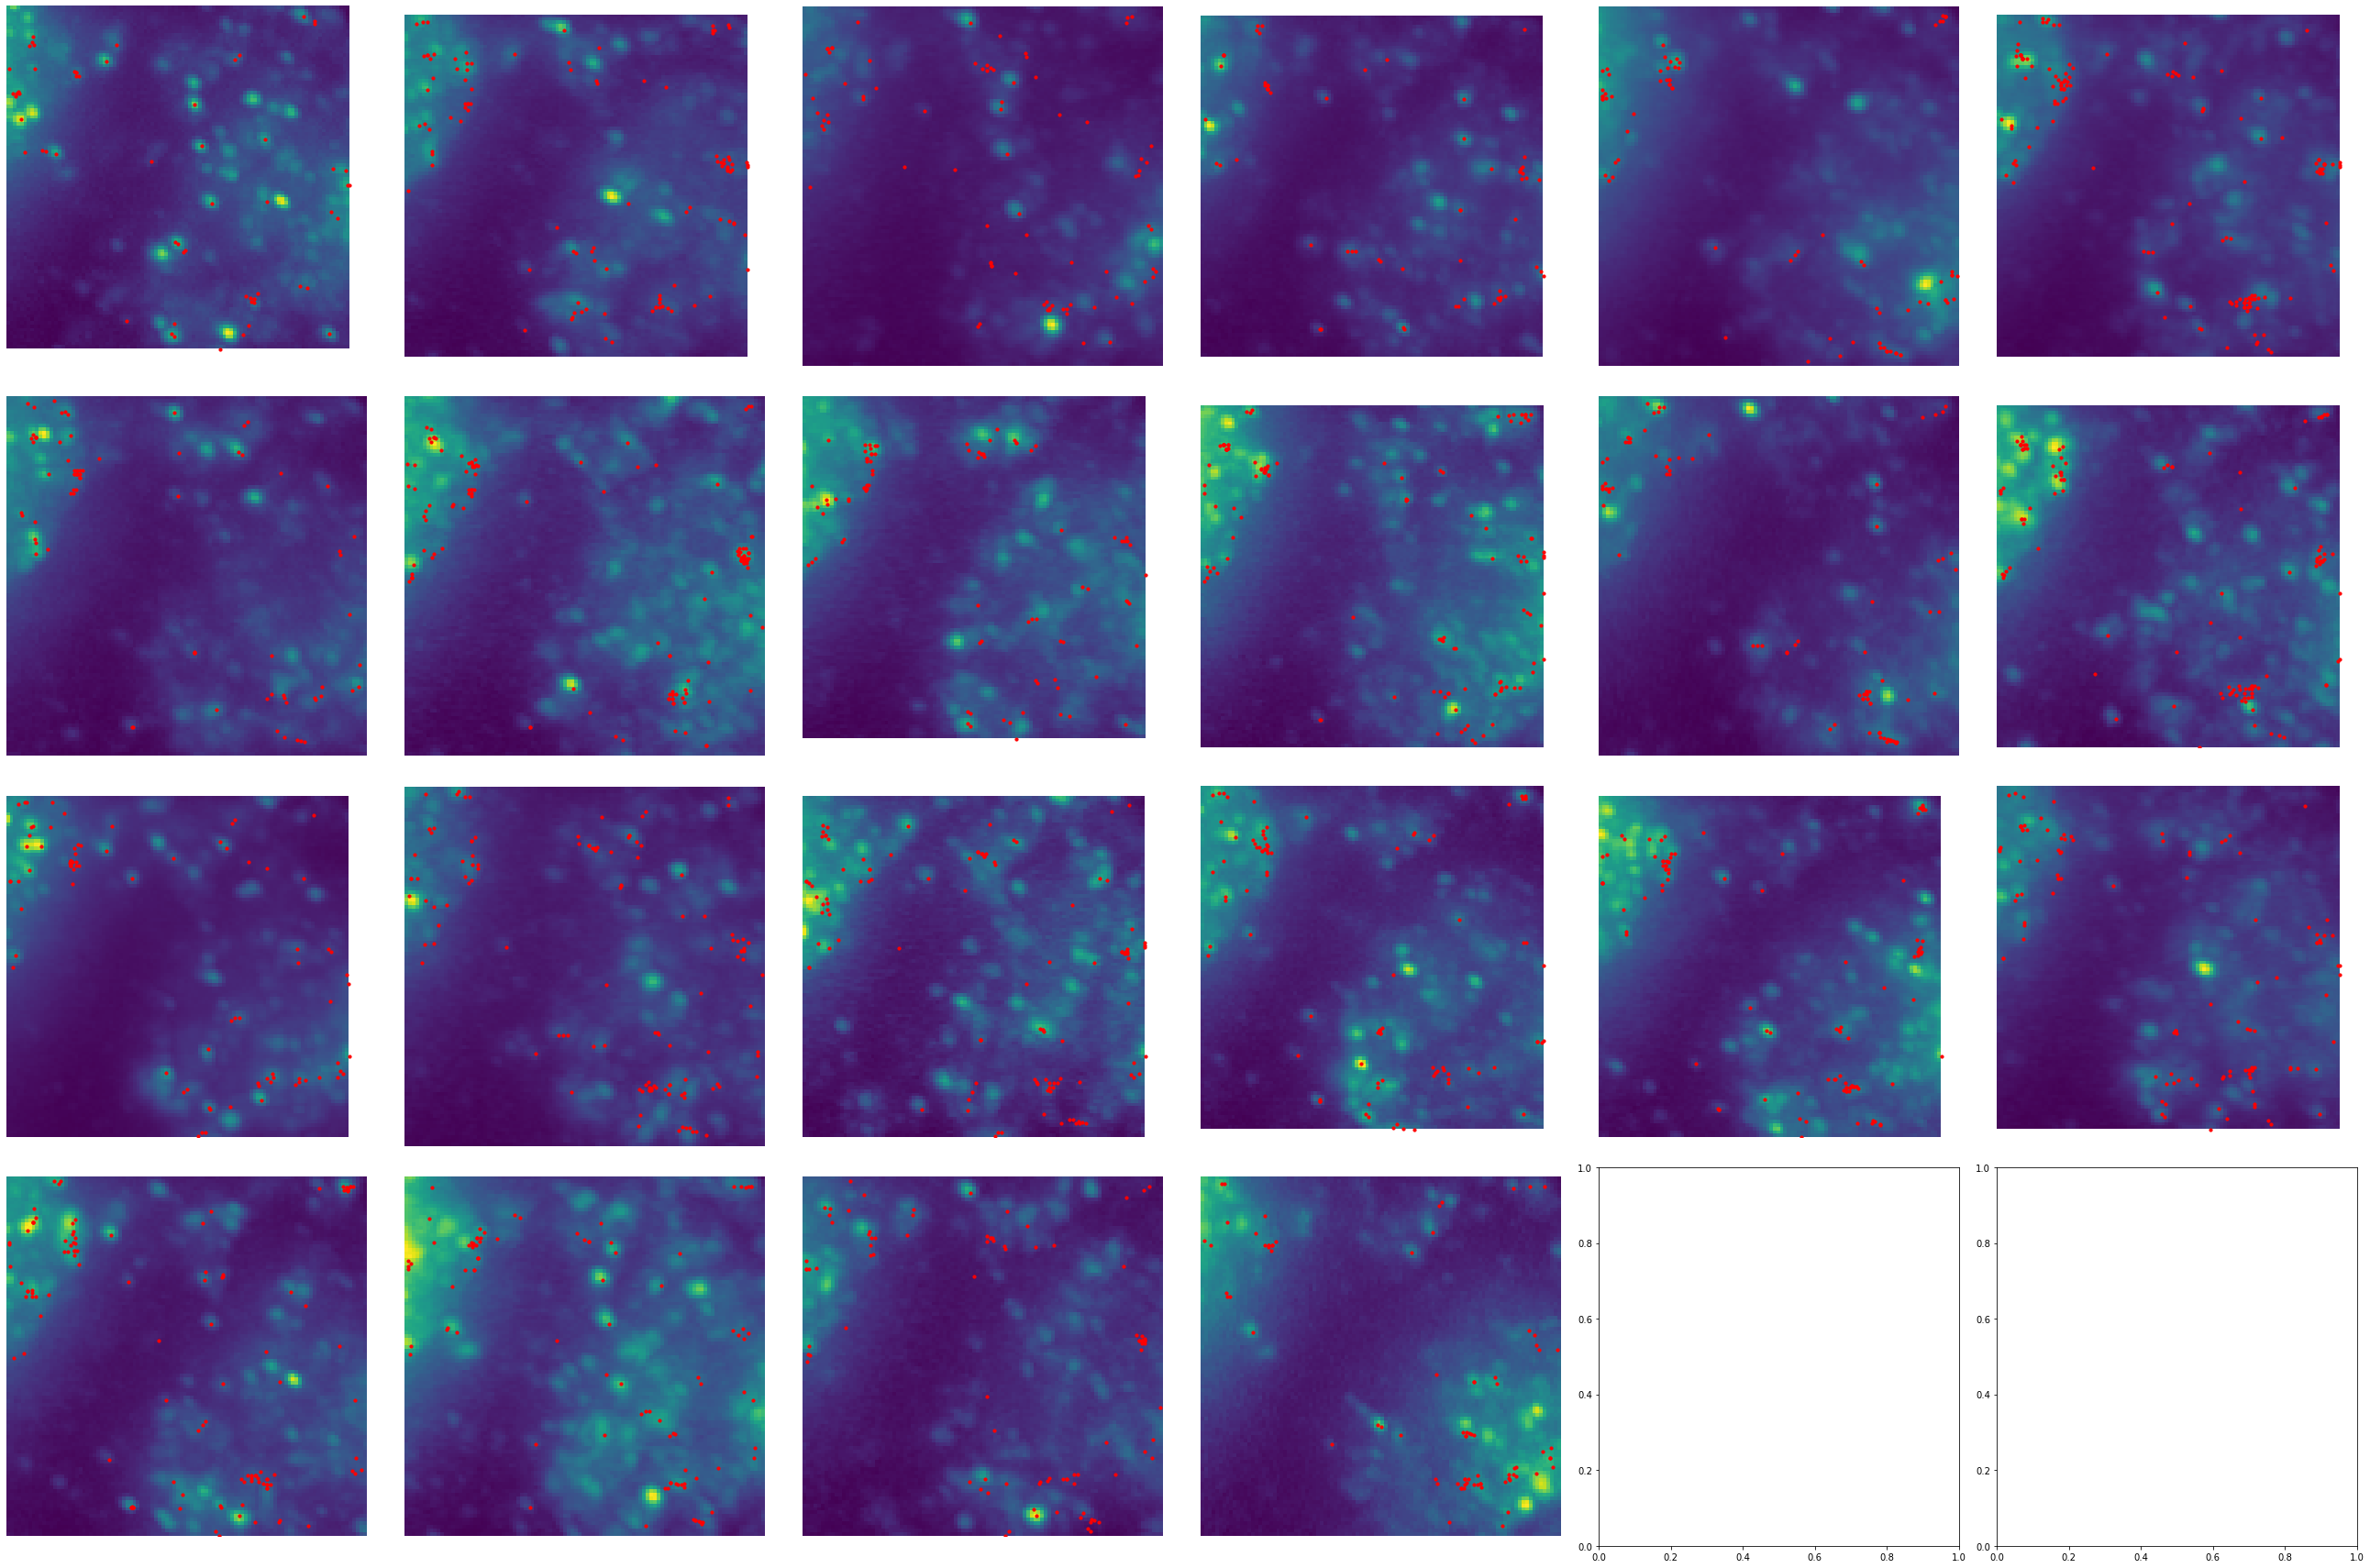

In [203]:
_ = plot_channels(cpu(x[0]), n_rows=4, df=pred_df, codebook=code_ref)

(4, 6)


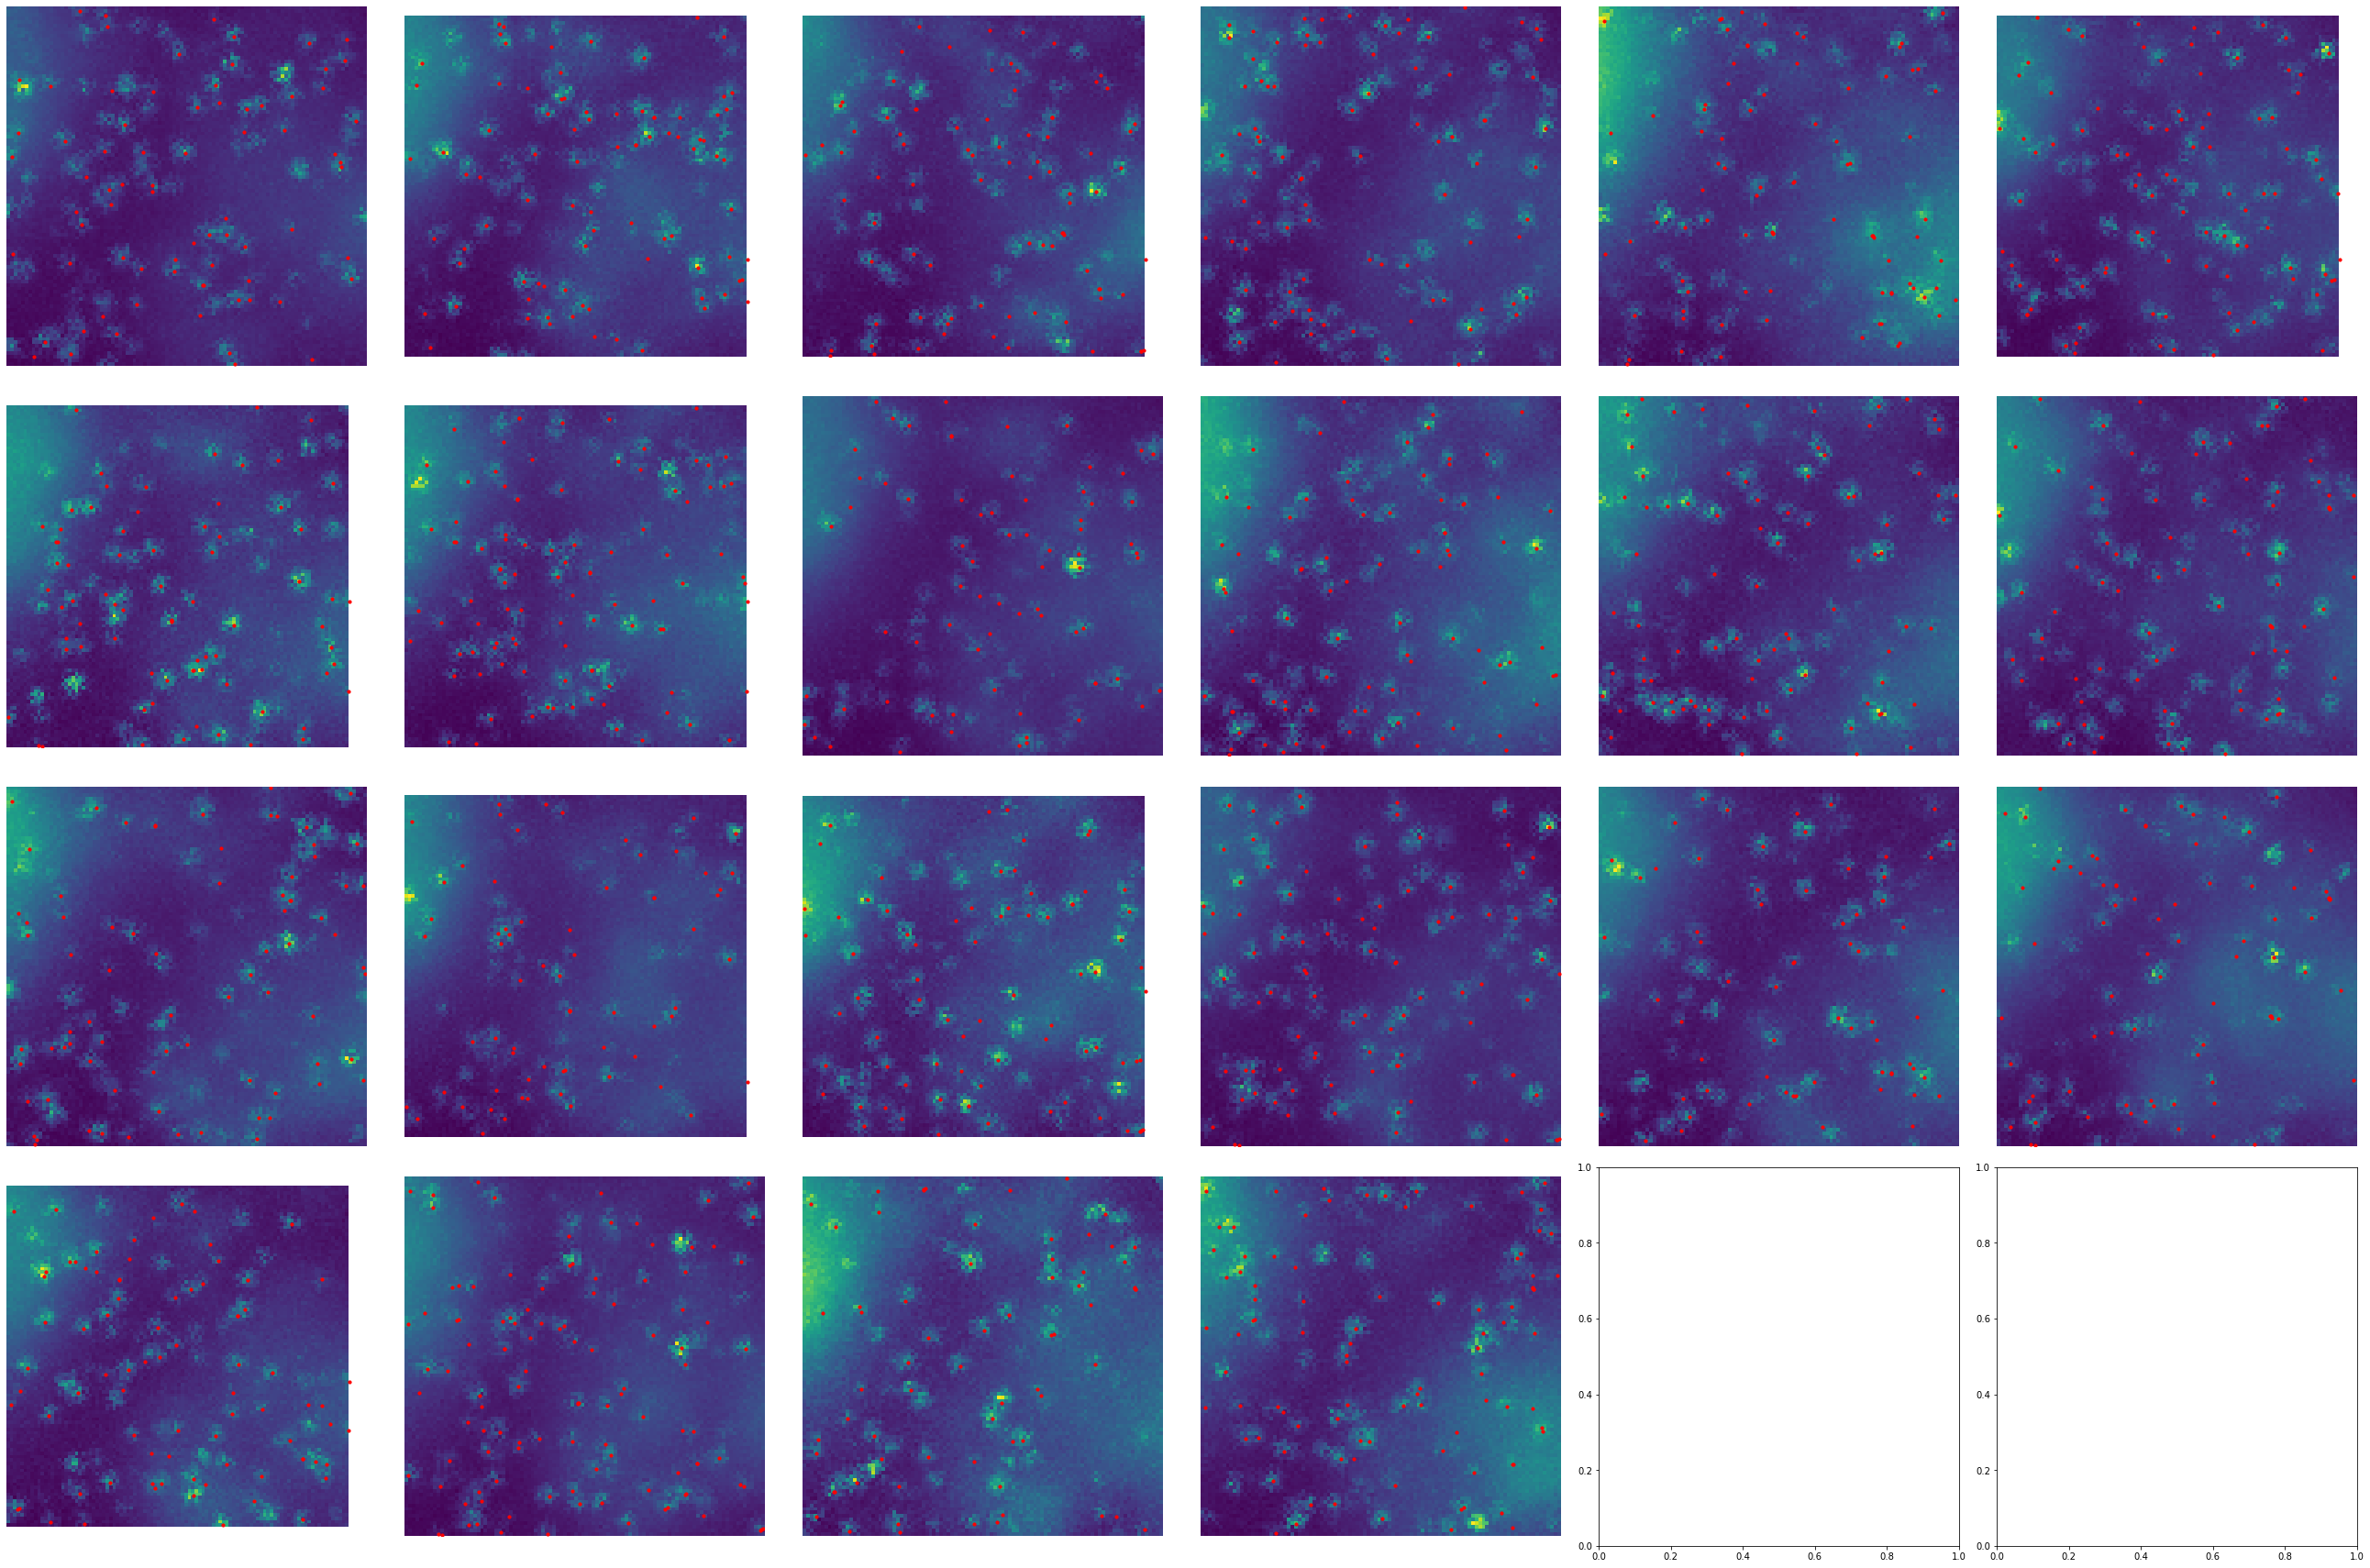

In [204]:
_ = plot_channels(cpu(xsimn[0]), n_rows=4, df=pred_df_sim, codebook=code_ref, vmax=None)

In [205]:
perf, matches, _ = matching(px_to_nm(gt_df), px_to_nm(pred_df_sim), tolerance=500, print_res=True, match_genes=True)

Recall: 0.597
Precision: 0.941
Jaccard: 57.584
RMSE_vol: 62.254
Eff_3d: 47.388
FN: 289.0 FP: 27.0
Num. matches: 429.000
Shift: 0.96,-1.48,51.59


In [436]:
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *

def sim_data(decode_dl, batches, micro, model, channels=1, n_bits=1, sim_z=True, codebook=None):
    
    gt_dfs = []
    xsim_col = []
    
    for _ in range(batches):
        with torch.no_grad():
            x, local_rate, background = next(iter(decode_dl))
            sim_vars = PointProcessUniform(local_rate[:,0] ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=channels, n_bits=n_bits, sim_z=sim_z, codebook=codebook, int_option=cfg.training.int_option).sample(from_code_book=(codebook is not None))
            xsim = micro(*sim_vars[:-1])
#             x = micro.noise(xsim, background*0 + background.mean()).sample()
            x = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

            xsim_col.append(x)

            gt_vars = sim_vars[:-2]
            gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
            gt_dfs.append(gt_df)
        
    return torch.cat(xsim_col), cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        with torch.no_grad():
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True)
            pred_dfs.append(pred_df)
            x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
    xrec = torch.cat(x_recs)
    perf, matches, _ = matching(gt_df, pred_df, tolerance=1000, print_res=print_res, match_genes=True)
    perf['mae'] = abs(xrec-rec).mean().item()
    perf['rmse'] = torch.sqrt(((xrec-rec)**2).mean()).item()
    
    return perf, pred_df, matches, xrec

In [437]:
# from decode_fish.funcs.routines import *
xsim, gt = sim_data(decode_dl, 5, micro, model, channels=22, n_bits=4, sim_z=cfg.genm.exp_type.pred_z, codebook=torch.tensor(code_ref))
perf, pred_df, matches, rec = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

Recall: 0.670
Precision: 0.781
Jaccard: 56.350
RMSE_vol: 426.234
Eff_3d: -117.541
FN: 1432.0 FP: 816.0
Num. matches: 2902.000
Shift: -1.11,1.39,369.41


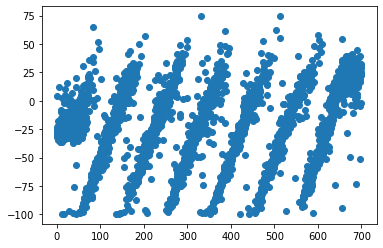

In [438]:
plt.scatter(matches['z_tar'], matches['z_pred'])

If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

In [ ]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_14/int_option:1//train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_14c/loss_option:1xcount_mult:0xcat_logits:0/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_19b/start_mic:200000xstart_int:200000xrate_fac:0xn_dump_codes:0xbs:3/train.yaml')

In [ ]:
# cfg.output.save_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/nb_run/test/'

In [409]:
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (7, 48, 48)
1 volumes


In [410]:
from monai.inferers import sliding_window_inference
from decode_fish.funcs.exp_specific import *
def merfish_predict(model, post_proc, image_paths, window_size=[None,256,256], device='cuda'):
    pred_df = DF()
    with torch.no_grad():
        for p in image_paths:
#             print(p.split('/')[-1])
#             img = load_tiff_image(p)[None]
            img = read_MOp_tiff(p)[None]
    
            n_chans = img.shape[1]
            z, y, x = img.shape[-3:]
                
            inp = img[:,:,:,500:1500,500:1500]
            output = sliding_window_inference(inp, window_size, 1, model.to(device), overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
            output = model.tensor_to_dict(output)
            p_si = sliding_window_inference(output['logits'], [None,64,64], 1, post_proc, overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
            i_df = post_proc.get_df(output, p_si)
#             print('N. emitters: ', len(i_df))
            i_df.loc[:,'frame_idx'] = 0
            pred_df = append_emitter_df(pred_df, i_df)
            free_mem()
        return pred_df

In [441]:
res_df = merfish_predict(model, post_proc, [cfg.evaluation.code_stats.image_path], window_size=[None, 256, 256], device='cuda')
# res_df = exclude_borders(res_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])
# res_df['z'] = res_df['z']*10 + 500

In [385]:
def get_merfish_mop(return_bench_df=False, mouse=1, sample=1, n_genes=252):

    mop_path = base_path +'/datasets/CodFish/MERFISH/MOp/'
    
    code_ref = pd.read_csv(mop_path + '/additional_files/codebook.csv')
    code_ref = code_ref.loc[:,code_ref.columns[2:]].values.astype('int8')
    targets = open(mop_path + '/additional_files/genes_combinatorial.txt').read().split('\n')
    targets = np.concatenate([targets, [f'Blank-{i}' for i in range(1,11)]])
    targets = np.array(targets).astype('object')
    
    if return_bench_df:
        bench_df = pd.read_csv(mop_path + f'spots_mouse{mouse}sample{sample}.csv')
        bench_df.columns = ['loc_idx', 'x', 'y', 'z', 'gene']
        bench_df['frame_idx'] = 0
        bench_df[['x','y','z']] = 1000*bench_df[['x','y','z']] # um to nm
        
        t_dict = {}
        for i,k in enumerate(targets):
            t_dict[k] = i
            
        code_inds = [t_dict[x] for x in bench_df['gene']]
        bench_df['code_inds'] = code_inds
        
        print(len(bench_df))
    else:
        bench_df = None

    return bench_df, code_ref[:n_genes], targets[:n_genes]

In [412]:
from decode_fish.funcs.merfish_eval import *
# bench_df, code_ref, targets = hydra.utils.instantiate(cfg.codebook, return_bench_df=True)
bench_df, code_ref, targets = get_merfish_mop(return_bench_df=True)
bench_df = get_mop_fov(bench_df, 150)
bench_df = nm_to_px(bench_df, [1.085,1.085,1.085])

17130008


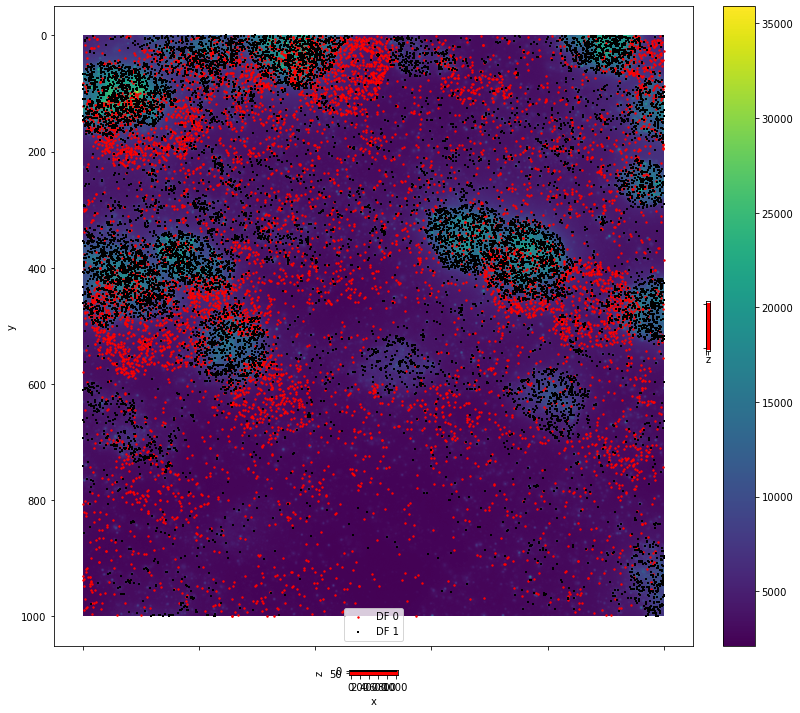

In [445]:
fig, axes = plot_3d_projections(img_3d[0][0,:,500:1500,500:1500], size=10)
bench_sub = crop_df(bench_df, np.s_[:,:,500:1500,500:1500], px_size_zyx=[100., 100., 100.])
# res_sub = crop_df(res_df, np.s_[:,:,500:1000,500:1000], px_size_zyx=[100., 100., 100.])
res_sub = res_df

scat_3d_projections(axes, [nm_to_px(bench_sub, [100.,100.,100.]), nm_to_px(res_sub.nsmallest(20000, 'comb_sig'), [100,100,100])], s_fac=0.2)

In [414]:
bench_sub['z'] = bench_sub['z']/1000
res_sub['z'] = res_sub['z']/1000

In [236]:
from decode_fish.funcs.evaluation import matching
perf_dict, match_df, shifts = matching(bench_sub,  res_sub.nsmallest(5000, 'comb_sig'), tolerance=500,)

Recall: 0.320
Precision: 0.565
Jaccard: 25.694
RMSE_vol: 113.539
Eff_3d: 6.490
FN: 5991.0 FP: 2176.0
Num. matches: 2824.000
Shift: -67.01,-68.32,0.00


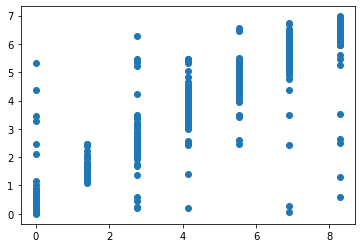

In [218]:
plt.scatter(match_df['z_tar'], match_df['z_pred'])

In [232]:
res_df['gene'] = targets[res_df['code_inds']]

8815 6000


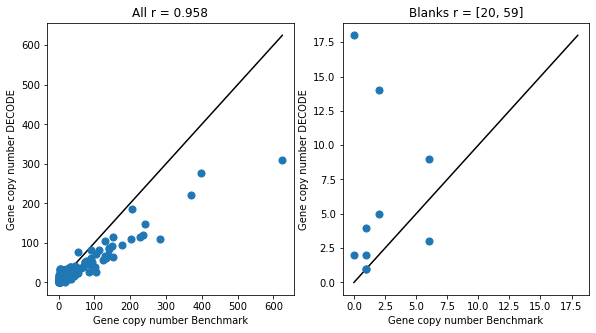

In [241]:
plot_gene_panels(res_sub.nsmallest(6000, 'comb_sig'), bench_sub, targets)

In [446]:
res_high = res_sub.nlargest(20000, 'comb_sig')
res_low = res_sub.nsmallest(5000, 'comb_sig')

In [394]:
res_high.keys()

Index(['loc_idx', 'frame_idx', 'code_inds', 'x', 'y', 'z', 'prob', 'int',
       'int_sig', 'x_sig', 'y_sig', 'z_sig', 'comb_sig'],
      dtype='object')

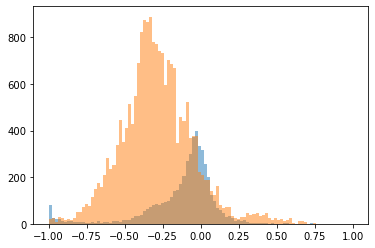

In [450]:
_ = plt.hist(res_low['z']/100, alpha=0.5, bins=np.linspace(-1,1,101))
_ = plt.hist(res_high['z']/100, alpha=0.5, bins=np.linspace(-1,1,101))

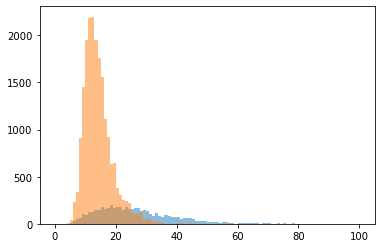

In [391]:
_ = plt.hist(res_low['int'], alpha=0.5, bins=np.linspace(0,100,101))
_ = plt.hist(res_high['int'], alpha=0.5, bins=np.linspace(0,100,101))

In [84]:
matches, bench_match = match_bench(res_df.nsmallest(15000, 'comb_sig'), bench_df)

[-64.44552350347162, -70.06390400883089, -56.111649826769195]
Recall: 0.056
Precision: 0.173
Jaccard: 4.385
RMSE_vol: 125.632
Eff_3d: -14.403
FN: 44022.0 FP: 12412.0
Num. matches: 2588.000
Shift: 0.11,-1.06,-41.98


(array([4323., 6979.,    0., 7738.,    0., 8176., 8164.,    0., 6786.,
        4444.]),
 array([   0.        ,  829.49308756, 1658.98617512, 2488.47926267,
        3317.97235023, 4147.46543779, 4976.95852535, 5806.4516129 ,
        6635.94470046, 7465.43778802, 8294.93087558]),
 <BarContainer object of 10 artists>)

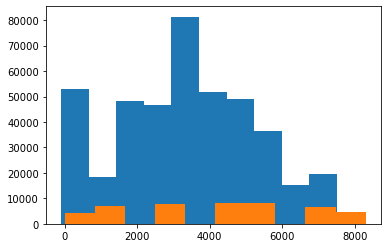

In [77]:
plt.hist(res_df['z'])
plt.hist(bench_df['z'])

In [ ]:
res_df = exclude_borders(inf_dfs, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])
res_df['gene'] = targets[res_df['code_inds']]
res_df = res_df[res_df['gene'] != 'MALAT1'] 
res_df_s = remove_doublets(res_df)

In [ ]:
# res_df1.to_csv(f'../data/results/MERFISH/test.csv', index=False)

In [28]:
matches, bench_match = match_bench(res_df, bench_df)

KeyError: 'code_inds'

In [287]:
(bench_sub['z']*1000).unique()

array([0.        , 1.38248848, 2.76497696, 4.14746544, 5.52995392,
       6.9124424 , 8.29493088])